## Generate Pangolin similar data for training

In [1]:
import pandas as pd
import numpy as np
import torch
import gffutils
import glob
from pyfaidx import Fasta
from collections import defaultdict
from packages.visual_utils import *
from packages.data_utils import *

In [2]:
# ---- Configurable Parameters ----
FASTA_PATH = "./raw_data/annotation/GRCh38.primary_assembly.genome.fa"          # reference genome (e.g., GRCh38.fa)
DB_PATH = "/home/xli_p14/github/DL_RNA_Splicing/raw_data/annotation/gencode.v48.annotation.db"
BLOCK_SIZE = 15000
PADDING = 5000

# ---- Load genome FASTA ----
genome = Fasta(FASTA_PATH)

In [23]:
### Step 1: merge expression

GEX_files = glob.glob("raw_data/gene_count/*counts.txt")
# Initialize empty list to collect dataframes
df_list = []

for filepath in GEX_files:
    # Use filename (without extension) as sample name
    sample_name = filepath.split("/")[-1].split(".")[0]
    
    # Read file with gene ID as index
    df = pd.read_csv(filepath, sep="\t", header=None, index_col=0)
    df.columns = [sample_name]  # Rename single column to sample name
    
    df_list.append(df)

# Merge all DataFrames on index (gene ID)
merged_df = pd.concat(df_list, axis=1)

# Result: rows = genes, columns = samples
print("Merged expression matrix shape:", merged_df.shape)

# Step 2: Load database
db = gffutils.FeatureDB(DB_PATH)

# Step 3: Calculate gene lengths (union of exon intervals per gene)
gene_lengths = {}
for gene in db.features_of_type('gene'):
    try:
        exons = list(db.children(gene, featuretype='exon', order_by='start'))
        if not exons:
            continue
        # Union exon spans
        intervals = []
        for exon in exons:
            intervals.append((exon.start, exon.end))
        # Merge overlapping intervals
        intervals.sort()
        merged = []
        current_start, current_end = intervals[0]
        for start, end in intervals[1:]:
            if start <= current_end:
                current_end = max(current_end, end)
            else:
                merged.append((current_start, current_end))
                current_start, current_end = start, end
        merged.append((current_start, current_end))
        # Sum total length
        total_length = sum(end - start + 1 for start, end in merged)
        gene_lengths[gene.id] = total_length
    except Exception as e:
        print(f"Failed on gene {gene.id}: {e}")

# Step 4: Save as TSV
length_df = pd.DataFrame.from_dict(gene_lengths, orient='index', columns=['length'])
length_df.index.name = 'gene_id'
length_df.to_csv("gencode.v48.gene_lengths.tsv", sep='\t')

# Load expression matrix
# Rows = genes, Columns = samples
expr_df = merged_df.iloc[0:-5, :]

# Load gene lengths (must match index of expr_df)
# Example format: gene_id \t length
gene_lengths = length_df['length']

# Filter to common genes
common_genes = expr_df.index.intersection(gene_lengths.index)
expr_df = expr_df.loc[common_genes]
gene_lengths = gene_lengths.loc[common_genes]

# Normalize counts to TPM
def counts_to_tpm(counts, lengths):
    rpk = counts.div(lengths, axis=0)  # reads per kilobase
    scaling_factor = rpk.sum(axis=0) / 1e6  # per sample
    return rpk.div(scaling_factor, axis=1)

tpm_df = counts_to_tpm(expr_df, gene_lengths)

# Save result
tpm_df.to_csv("combined_expression_matrix.TPM.tsv", sep='\t', float_format='%.3f')

In [3]:
tpm_df = pd.read_csv("combined_expression_matrix.TPM.tsv", sep='\t').set_index('gene_id')
gene_select = tpm_df.std(axis = 1).nlargest(10).index

tpm_df = tpm_df.loc[gene_select, :]
normalized_df = tpm_df.sub(tpm_df.min(axis=1), axis=0).div(tpm_df.max(axis=1) - tpm_df.min(axis=1), axis=0).fillna(0)
normalized_df = normalized_df.round(3)

#normalized_df.to_csv("var_top10_exp.TPM.tsv", sep='\t')

In [19]:
## merge gene
# --- Constants ---
DB_PATH = "/home/xli_p14/github/DL_RNA_Splicing/raw_data/annotation/gencode.v48.annotation.db"
MAJIQ_TSV = "./raw_data/PSI/2027sTS.psi.tsv"
PADDING = 5000
BLOCK_SIZE = 15000

# Load MAJIQ quantification file
majiq_df = pd.read_csv(MAJIQ_TSV, sep="\s+")[0:1]

# Group rows by gene_id
gene_groups = defaultdict(list)
for _, row in majiq_df.iterrows():
    gene_groups[row['gene_id']].append(row)

# Prepare training data
training_input = []
training_label = []

for gene, rows in gene_groups.items():
    psi_map = {}
    # Merge PSI values from all LSVs of the same gene
    for row in rows:
        psi_values = list(map(float, row['mean_psi_per_lsv_junction'].split(';')))
        junction_coords = row['junctions_coords'].split(';')
        for junc, psi in zip(junction_coords, psi_values):
            try:
                start, end = parse_coords(junc)
                psi_map[start] = psi
                psi_map[end] = psi
            except Exception as e:
                print(f"Failed to parse junction '{junc}': {e}")
                continue

    # Get gene region
    result = get_gene_bounds(gene, DB_PATH)
    if result is None:
        print(f"Skipping {gene} – gene bounds not found.")
        continue
    chrom, strand, tss, tes = result
    print(f"Gene: {gene} – Coordinates: {chrom} {strand} {tss} {tes}")
    
    # Create sequence blocks
    start = min(tss, tes)
    end = max(tss, tes)
    blocks = make_blocks(start, end, chrom, genome, PADDING, BLOCK_SIZE)
    for block_start, block_end, seq in blocks:
        if seq.count('N')>= PADDING:
            print (seq.count('N'), "out of ", BLOCK_SIZE, "Skip")
            continue
        X = one_hot_encode(seq)  # Shape: [4, BLOCK_SIZE]
        y = assign_labels(block_start, block_end, psi_map, PADDING, BLOCK_SIZE)  # Shape: [12, label_len]
        training_input.append(torch.tensor(X, dtype=torch.float32))
        training_label.append(torch.tensor(y, dtype=torch.float32))

print(f"✅ Prepared {len(training_input)} training blocks from gene-merged junctions.")
torch.save({'X': training_input, 'y': training_label}, "gene_merged_training_data.pt")

Gene: ENSG00000290825.2 – Coordinates: chr1 + 11121 24894
✅ Prepared 1 training blocks from gene-merged junctions.


In [61]:
#psi_map
#blocks
#get_gene_bounds(gene, DB_PATH)
#make_blocks(11121, 24894, chrom, genome, PADDING, BLOCK_SIZE)

In [11]:
#decode_one_hot(training_input[odr])

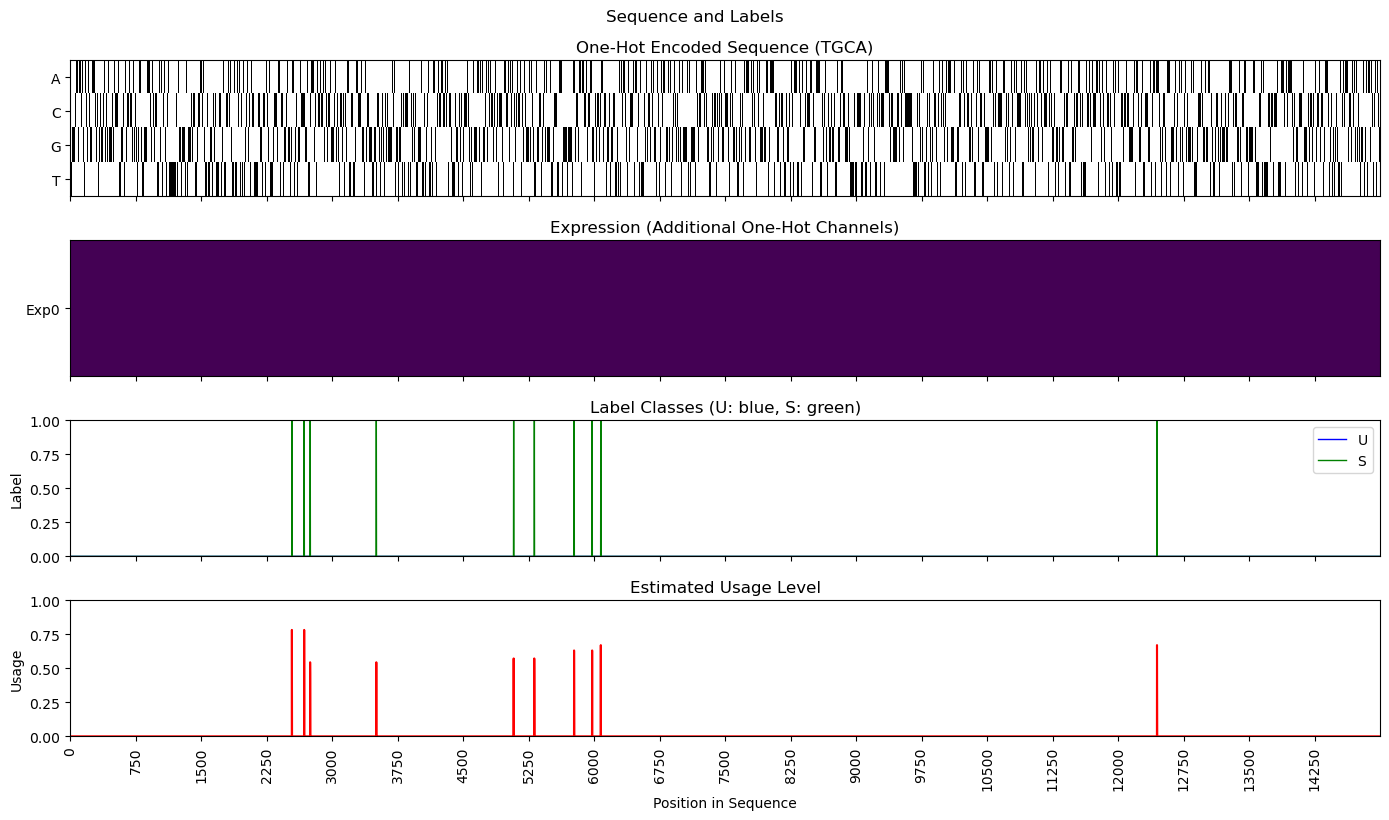

In [41]:
odr=4
plot_one_hot_and_labels_zoom(training_input[odr], training_label[odr], zoom_start=0, zoom_end=15000, title="Sequence and Labels")

In [4]:
def Write_Training_Data_From_EXP_PSI(normalized_df, _out_path="default_training_data.pt"):
    training_input = []
    training_label = []
    genome = Fasta(FASTA_PATH)

    for sample_id in normalized_df.columns:
        print(f"Processing sample: {sample_id}")
    
        # Find TSV files matching this sample_id
        tsv_files = glob.glob(f"raw_data/PSI/*{sample_id}*.psi.tsv")
        if not tsv_files:
            print(f"  No PSI TSV files found for sample {sample_id}, skipping.")
            continue
    
        for MAJIQ_TSV in tsv_files:
            #print(f"  Processing file: {MAJIQ_TSV}")
            try:
                majiq_df = pd.read_csv(MAJIQ_TSV, sep="\s+")[0:20]  # optionally limit for speed
            except Exception as e:
                print(f"Failed to load {MAJIQ_TSV}: {e}")
                continue

            # Group rows by gene_id
            gene_groups = defaultdict(list)
            for _, row in majiq_df.iterrows():
                gene_groups[row['gene_id']].append(row)

            for gene, rows in gene_groups.items():
                psi_map = {}
                # Merge PSI values from all LSVs of the same gene
                for row in rows:
                    psi_values = list(map(float, row['mean_psi_per_lsv_junction'].split(';')))
                    junction_coords = row['junctions_coords'].split(';')
                    for junc, psi in zip(junction_coords, psi_values):
                        try:
                            start, end = parse_coords(junc)
                            psi_map[start] = psi
                            psi_map[end] = psi
                        except Exception as e:
                            print(f"Failed to parse junction '{junc}': {e}")
                            continue
            
                # Get gene region
                result = get_gene_bounds(gene, DB_PATH)
                if result is None:
                    print(f"Skipping {gene} – gene bounds not found.")
                    continue
                chrom, strand, tss, tes = result
                #print(f"Gene: {gene} – Coordinates: {chrom} {strand} {tss} {tes}")

                # Get expression vector for this block by sample
                expr_vec = normalized_df.loc[:, sample_id].values  # shape: (10,)
                expr_tensor = torch.tensor(expr_vec, dtype=torch.float32).view(-1, 1).repeat(1, BLOCK_SIZE)  # [10, 15000]
                
                # Create sequence blocks
                start = min(tss, tes)
                end = max(tss, tes)
                blocks = make_blocks(start, end, chrom, genome, PADDING, BLOCK_SIZE)
                
                for block_start, block_end, seq in blocks:
                    if seq.count('N')>= PADDING:
                        print (seq.count('N'), "out of ", BLOCK_SIZE, "Skip")
                        continue
                    seq_tensor = torch.tensor(one_hot_encode(seq), dtype=torch.float32)  # [4, 15000]
                    X = torch.cat([seq_tensor, expr_tensor], dim=0)  # [14, 15000]
                    y = torch.tensor(assign_labels(block_start, block_end, psi_map, PADDING, BLOCK_SIZE), dtype=torch.float32)
                    training_input.append(X)
                    training_label.append(y)
    torch.save({'X': training_input, 'y': training_label}, _out_path)
    print(f"Saved {len(training_input)} samples to {_out_path}")
    return None

In [5]:
normalized_df = pd.read_csv("var_top10_exp.TPM.tsv", sep='\t').set_index('gene_id')
normalized_df = normalized_df.loc[:, ["2027sTS"]] #normalized_df.iloc[:, 0:20]
Write_Training_Data_From_EXP_PSI(normalized_df, "2027sTS_training_data_sequece_exp.pt")

Processing sample: 2027sTS
Saved 5 samples to 2027sTS_training_data_sequece_exp.pt


In [22]:
!aws s3 cp 20Samples_training_data_sequece_exp.pt s3://research.luffingfuturellc/Pangolin/

upload: ./20Samples_training_data_sequece_exp.pt to s3://research.luffingfuturellc/Pangolin/20Samples_training_data_sequece_exp.pt


In [28]:

#Plot_2D_Array(training_label[1])

In [ ]:
def count_N_from_one_hot(one_hot_tensor):
    # one_hot_tensor: torch.Tensor of shape [4, length]
    # Sum over rows (channels), find where the sum is 0
    zero_cols = torch.sum(one_hot_tensor, dim=0) == 0
    return torch.sum(zero_cols).item()

## validation from PSI to Label

In [5]:
def Plot_2D_Array(array):
    ## 2D torch tensor, shape =  torch.Size([3, 15000])
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
    colors = ['gray', 'blue', 'red']
    labels = ['Un', 'S', 'Usage']
    # X-axis (sequence positions)
    x = np.arange(len(array[0]))
    
    for i in range(3):
        axes[i].plot(x, array[i], color = colors[i])
        axes[i].set_ylabel(labels[i])
        axes[i].set_ylim(0, 1)
        axes[i].grid(True)
    
    axes[-1].set_xlabel("Sequence Position")
    fig.suptitle("Individual Class Predictions Over Sequence", y=1.02)
    plt.tight_layout()
    plt.show()
    return None

In [8]:
## validation from PSI to Label
#class_labels = assign_labels(block_start, block_end, psi_map, PADDING, BLOCK_SIZE)
#Plot_2D_Array(class_labels)

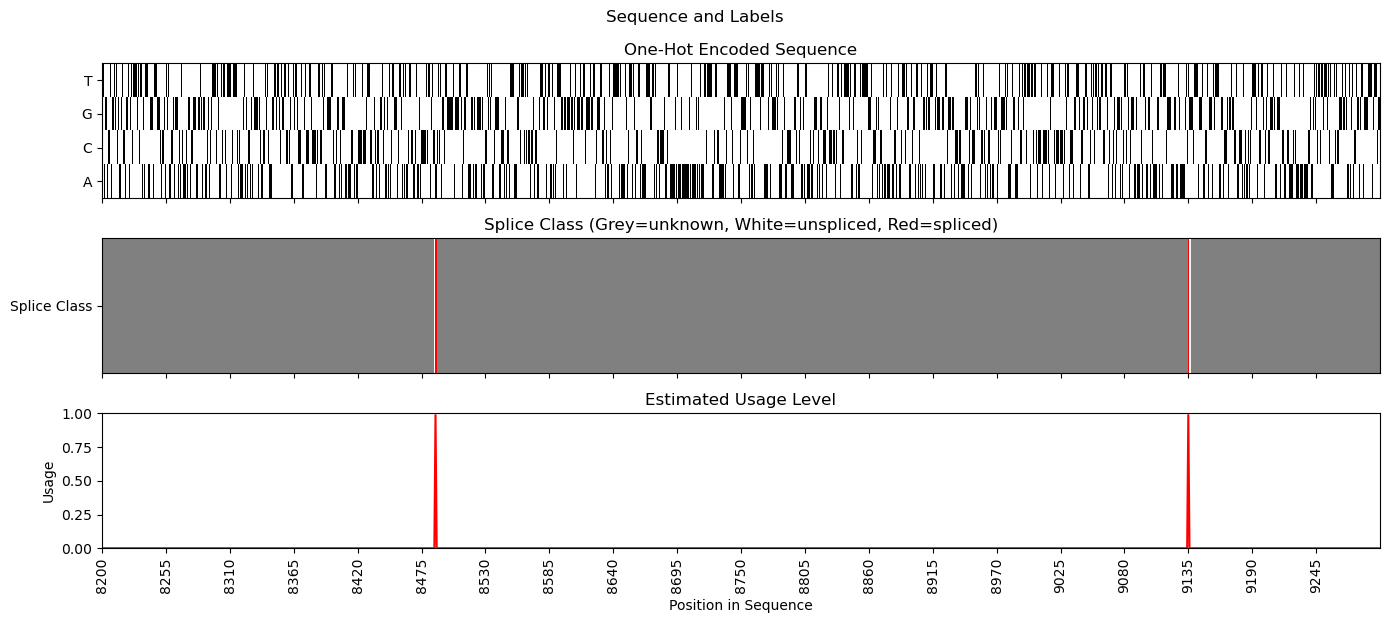

In [6]:
cor_start = 8200
cor_end = 9300
plot_one_hot_and_labels_zoom(training_input[0], training_label[0], zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")

In [ ]:
## Test

In [5]:
gene = "ENSG00000070019.5"
get_gene_bounds(gene, DB_PATH)
#print (tss, tes, chrom, genome, PADDING)
#majiq_df.head(0)
gene = "ENSG00000162365.12"
get_gene_bounds(gene, DB_PATH)

('chr1', '+', 47137435, 47149735)

In [31]:
print(f"Prepared {len(training_data)} training blocks.")


Prepared 105 training blocks.


In [11]:
training_data[0][0]
training_data[0][1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 15000))

In [52]:
data_for_plot[1][:, 0].argmax()
data_for_plot[1][:, 1].argmax()
data_for_plot[1][:, 2].argmax()

np.int64(8811)

In [22]:
data_for_plot[1][:, 8811]

array([0.    , 1.    , 0.9877])

In [24]:
#decode_one_hot(data_for_plot[0].T)